In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget


In [2]:
sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.01), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

In [3]:
b = bagreader('/home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/lab/eval_new_PT/test1/2023-03-24-15-27-21.bag')

b.topic_table

[INFO]  Data folder /home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/lab/eval_new_PT/test1/2023-03-24-15-27-21 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,2012,30.245567
1,/anafi/gnss_location,sensor_msgs/NavSatFix,2012,30.412239
2,/anafi/height,olympe_bridge/Float32Stamped,2012,30.235320
3,/anafi/image,sensor_msgs/Image,2011,30.290782
4,/anafi/odometry,nav_msgs/Odometry,2010,22.764942
5,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,2010,30.296908
6,/anafi/polled_body_velocities,geometry_msgs/TwistStamped,336,4.997026
7,/anafi/pose,geometry_msgs/PoseStamped,2011,30.205598
8,/anafi/rpy,geometry_msgs/Vector3Stamped,3930,95.286110
9,/estimate/aprilTags/num_tags_detected,anafi_uav_msgs/Float32Stamped,673,10.722431


In [4]:
gt_anafi_pose = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pose = pd.read_csv(gt_anafi_pose)

df_gt_anafi_pose = drop_columns_in_df(df_gt_anafi_pose)
df_gt_anafi_pose.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_anafi_pose = rename_columns(df_gt_anafi_pose, ["anafi_x", "anafi_y", "anafi_z"])

df_gt_anafi_pose

,Time,anafi_x,anafi_y,anafi_z
0,1.679668e+09,-0.218540,-0.321283,-0.143034
1,1.679668e+09,-0.218732,-0.320954,-0.142909
2,1.679668e+09,-0.218577,-0.321284,-0.143020
3,1.679668e+09,-0.218821,-0.320982,-0.143097
4,1.679668e+09,-0.218742,-0.320938,-0.142894
...,...,...,...,...
4498,1.679668e+09,-0.547481,-0.593668,-4.225492
4499,1.679668e+09,-0.547406,-0.593465,-4.221140
4500,1.679668e+09,-0.547275,-0.593361,-4.216940
4501,1.679668e+09,-0.547273,-0.592908,-4.208370


In [5]:
gt_platform_pose = b.message_by_topic('/qualisys/Platform/pose')
df_gt_platform_pose = pd.read_csv(gt_platform_pose)

df_gt_platform_pose = drop_columns_in_df(df_gt_platform_pose)
df_gt_platform_pose.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_platform_pose = rename_columns(df_gt_platform_pose, ["platform_x", "platform_y", "platform_z"])

df_gt_platform_pose

,Time,platform_x,platform_y,platform_z
0,1.679668e+09,-0.174997,-0.275202,-0.110308
1,1.679668e+09,-0.174984,-0.275177,-0.110328
2,1.679668e+09,-0.174989,-0.275184,-0.110314
3,1.679668e+09,-0.174970,-0.275171,-0.110338
4,1.679668e+09,-0.174996,-0.275164,-0.110320
...,...,...,...,...
6706,1.679668e+09,-0.174985,-0.275238,-0.110155
6707,1.679668e+09,-0.175003,-0.275243,-0.110140
6708,1.679668e+09,-0.174998,-0.275259,-0.110165
6709,1.679668e+09,-0.174999,-0.275253,-0.110111


In [6]:
# Load the drone orientation from the anafi
from math import degrees


gt_anafi_pose_NED = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pose_NED = pd.read_csv(gt_anafi_pose)

# Load the position of the platform
gt_platform_pose_NED = b.message_by_topic('/qualisys/Platform/pose')
df_gt_platform_pose_NED = pd.read_csv(gt_platform_pose)
df_gt_platform_pose_NED = drop_columns_in_df(df_gt_platform_pose_NED)
df_gt_platform_pose_NED.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
df_gt_platform_pose_NED = rename_columns(df_gt_platform_pose_NED, ["platform_x", "platform_y", "platform_z"])

# Sync the two dataframes based on timestamps
df_gt_NED = sync_dfs_based_on_time([df_gt_anafi_pose_NED, df_gt_platform_pose_NED])

# Create the rotation objects and apply the rotations to the pose of the platform
df_rotation_NED_to_body = df_gt_NED[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
# rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body)

rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body).as_euler("xyz", degrees=True)
rotation_NED_to_body[2,:] += 0
# np.array([np.array(rotation_NED_to_body[0,:]).T, np.array(rotation_NED_to_body[1,:]).T, np.array(rotation_NED_to_body[2,:]).T]).T
rotation_NED_to_body= Rotation.from_euler('xyz', rotation_NED_to_body, degrees=True).inv()


platform_pos_body = rotation_NED_to_body.apply(df_gt_NED[["platform_x", "platform_y", "platform_z"]])
df_platform_pos_body = pd.DataFrame(platform_pos_body)
df_platform_pos_body.columns = ["platform_x_body", "platform_y_body", "platform_z_body"]

# Get the anafi position in the body frame
anafi_pos_body = rotation_NED_to_body.apply(df_gt_NED[["pose.position.x", "pose.position.y", "pose.position.z"]])
df_anafi_pos_body = pd.DataFrame(anafi_pos_body)
df_anafi_pos_body.columns = ["anafi_x_body", "anafi_y_body", "anafi_z_body"]

conc = [df_gt_NED, df_platform_pos_body, df_anafi_pos_body]

df_positions_body = pd.concat(
    conc,
    axis=1,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

df_positions_body = df_positions_body[["Time", "platform_x_body", "platform_y_body", "platform_z_body", "anafi_x_body", "anafi_y_body", "anafi_z_body"]]

df_positions_body['drone_to_platform_body_x'] = df_positions_body["platform_x_body"] - df_positions_body["anafi_x_body"]
df_positions_body['drone_to_platform_body_y'] = df_positions_body["platform_y_body"] - df_positions_body["anafi_y_body"]
df_positions_body['drone_to_platform_body_z'] = df_positions_body["platform_z_body"] - df_positions_body["anafi_z_body"]

df_positions_body


,Time,platform_x_body,platform_y_body,platform_z_body,anafi_x_body,anafi_y_body,anafi_z_body,drone_to_platform_body_x,drone_to_platform_body_y,drone_to_platform_body_z
0,1.679668e+09,-0.312077,0.027706,-0.142718,-0.369387,0.044804,-0.181625,0.057310,-0.017098,0.038907
1,1.679668e+09,-0.312000,0.028336,-0.142763,-0.369090,0.045907,-0.181503,0.057090,-0.017570,0.038740
2,1.679668e+09,-0.312104,0.027780,-0.142594,-0.369480,0.044932,-0.181438,0.057376,-0.017152,0.038844
3,1.679668e+09,-0.311425,0.028329,-0.143974,-0.368423,0.045940,-0.183146,0.056998,-0.017611,0.039172
4,1.679668e+09,-0.311934,0.028402,-0.142824,-0.369050,0.046010,-0.181531,0.057116,-0.017608,0.038707
...,...,...,...,...,...,...,...,...,...,...
4498,1.679668e+09,-0.325391,0.033974,-0.107250,-0.810343,0.314663,-4.213228,0.484953,-0.280689,4.105978
4499,1.679668e+09,-0.325251,0.033692,-0.107710,-0.804172,0.314539,-4.210017,0.478921,-0.280847,4.102308
4500,1.679668e+09,-0.325268,0.033400,-0.107763,-0.803041,0.318489,-4.205694,0.477773,-0.285089,4.097932
4501,1.679668e+09,-0.325362,0.032972,-0.107662,-0.805691,0.309978,-4.197166,0.480329,-0.277006,4.089504


In [7]:
apriltag_pose = b.message_by_topic('/estimate/aprilTags/pose')
df_apriltag_pose = pd.read_csv(apriltag_pose)

df_apriltag_pose

df_apriltag_pose = drop_columns_in_df(df_apriltag_pose)

df_apriltag_pose = df_apriltag_pose[["Time", "x", "y", "z"]]

df_apriltag_pose = rename_columns(df_apriltag_pose, ["apriltag_x", "apriltag_y", "apriltag_z"])

df_apriltag_pose

,Time,apriltag_x,apriltag_y,apriltag_z
0,1.679668e+09,0.129538,-0.026248,0.189321
1,1.679668e+09,0.132082,-0.031727,0.278380
2,1.679668e+09,0.130340,-0.037616,0.341349
3,1.679668e+09,0.130027,-0.045839,0.438498
4,1.679668e+09,0.132995,-0.055351,0.534235
...,...,...,...,...
668,1.679668e+09,0.107113,0.001337,0.322081
669,1.679668e+09,0.106048,0.002240,0.287767
670,1.679668e+09,0.105863,0.003715,0.266379
671,1.679668e+09,0.107062,0.005617,0.231153


In [8]:
dnn_pose = b.message_by_topic('/estimate/dnn_cv/position')
df_dnn_pose = pd.read_csv(dnn_pose)

df_dnn_pose = drop_columns_in_df(df_dnn_pose)

df_dnn_pose = rename_columns(df_dnn_pose, ["dnn_x", "dnn_y", "dnn_z"])

In [13]:
ekf_pose = b.message_by_topic('/estimate/ekf')
df_ekf_pose = pd.read_csv(ekf_pose)

df_ekf_pose = drop_columns_in_df(df_ekf_pose)

df_ekf_pose

df_ekf_pose = rename_columns(df_ekf_pose, ["ekf_x", "ekf_y", "ekf_z"] + list(df_ekf_pose.columns[4:]))


,Time,pose.pose.position.x,pose.pose.position.y,pose.pose.position.z,pose.pose.orientation.x,pose.pose.orientation.y,pose.pose.orientation.z,pose.pose.orientation.w,pose.covariance
0,1.679668e+09,0.000000,0.000000,2.995036e+00,0.0,0.0,0.0,0.0,"(9.311840843524395, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
1,1.679668e+09,0.000000,0.000000,2.995036e+00,0.0,0.0,0.0,0.0,"(9.321518443524395, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,1.679668e+09,0.000000,0.000000,2.995036e+00,0.0,0.0,0.0,0.0,"(9.331535564480575, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
3,1.679668e+09,0.000000,0.000000,2.995036e+00,0.0,0.0,0.0,0.0,"(9.341601004799301, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,1.679668e+09,0.000000,0.000000,2.995036e+00,0.0,0.0,0.0,0.0,"(9.351746764480575, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
...,...,...,...,...,...,...,...,...,...
1673,1.679668e+09,0.205289,0.756648,1.913602e-09,0.0,0.0,0.0,0.0,"(0.2483952433356201, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1674,1.679668e+09,0.205289,0.756648,7.270524e-10,0.0,0.0,0.0,0.0,"(0.2584608433349614, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1675,1.679668e+09,0.205289,0.756648,2.712630e-10,0.0,0.0,0.0,0.0,"(0.268606762802739, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
1676,1.679668e+09,0.205289,0.756648,1.057587e-10,0.0,0.0,0.0,0.0,"(0.2784610009141678, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
anafi_height = b.message_by_topic('/anafi/height')
df_anafi_height = pd.read_csv(anafi_height)

df_anafi_height = drop_columns_in_df(df_anafi_height)

df_anafi_height = rename_columns(df_anafi_height, ["anafi_z"])

In [11]:
#NAN HANDLING AND NP ARRAY GENERATION

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

In [12]:
df_merged_position = sync_dfs_based_on_time([df_positions_body, df_apriltag_pose, df_dnn_pose, df_ekf_pose, df_anafi_height])

df_merged_position = normalize_df_time(df_merged_position)
# df_merged_position = df_merged_position.iloc[-970:]

apriltag_data = get_np_arr_without_nan(df_merged_position, ["apriltag_x", "apriltag_y", "apriltag_z"])
dnn_data = get_np_arr_without_nan(df_merged_position, ["dnn_x", "dnn_y", "dnn_z"])
GT_data = get_np_arr_without_nan(df_merged_position, ["drone_to_platform_body_x", "drone_to_platform_body_y", "drone_to_platform_body_z"])
ekf_data = get_np_arr_without_nan(df_merged_position, ["ekf_x", "ekf_y", "ekf_z", "covariance_0", "covariance_4", "covariance_8"])
# height_data = get_np_arr_without_nan(df_merged_position, ["anafi_z"])

KeyError: "['covariance_0', 'covariance_4', 'covariance_8'] not in index"

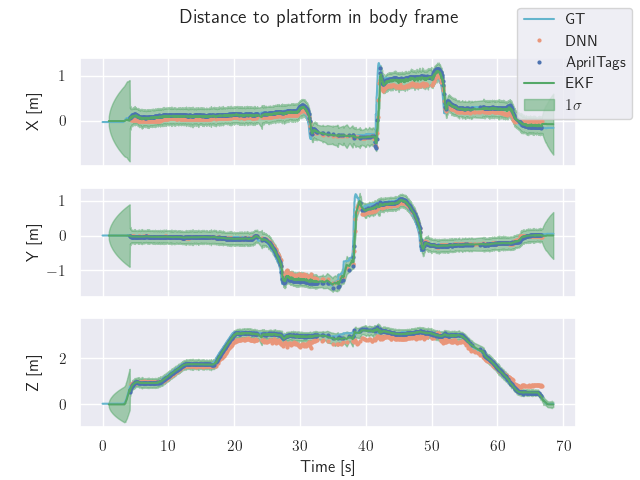

In [ ]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(GT_data[:,0], GT_data[:,1], c='c')
axs[0].plot(dnn_data[:,0], dnn_data[:,1], 'o', ms=2, c='darksalmon')
axs[0].plot(apriltag_data[:,0], apriltag_data[:,1], 'o', ms=2, c='b')
axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, color='g')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(GT_data[:,0], GT_data[:,2], c='c')
axs[1].plot(dnn_data[:,0], dnn_data[:,2], 'o', ms=2, c='darksalmon')
axs[1].plot(apriltag_data[:,0], apriltag_data[:,2], 'o', ms=2, c='b')
axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, color='g')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])





axs[2].plot(GT_data[:,0], GT_data[:,3], c='c')
axs[2].plot(dnn_data[:,0], dnn_data[:,3], 'o', ms=2, c='darksalmon')
axs[2].plot(apriltag_data[:,0], apriltag_data[:,3], 'o', ms=2, c='b')
axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, color='g')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT",  "DNN", "AprilTags", "EKF", r"$1\sigma$"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()


# PRINT RMSE

In [14]:
def make_rmse_dataframe(df, column_names_to_keep):
  df_reduced = df[column_names_to_keep]

  RMSE_df = Mask_Or_Drop_Successive_Identical_Values(df_reduced, drop=True)

  return RMSE_df


RMSE_df = make_rmse_dataframe(df_merged_position, ["drone_to_platform_body_x", "drone_to_platform_body_y", "drone_to_platform_body_z", "ekf_x", "ekf_y", "ekf_z"])

RMSE_df["x_diff"] = RMSE_df["drone_to_platform_body_x"] - RMSE_df["ekf_x"]
RMSE_df['x_diff'] = RMSE_df['x_diff'].apply(lambda x: x**2)
print("RMSE X: ", np.sqrt((RMSE_df["x_diff"]).mean()))

RMSE_df["y_diff"] = RMSE_df["drone_to_platform_body_y"] - RMSE_df["ekf_y"]
RMSE_df['y_diff'] = RMSE_df['y_diff'].apply(lambda x: x**2)
print("RMSE Y: ", np.sqrt((RMSE_df["y_diff"]).mean()))

RMSE_df["z_diff"] = RMSE_df["drone_to_platform_body_z"] - RMSE_df["ekf_z"]
RMSE_df['z_diff'] = RMSE_df['z_diff'].apply(lambda x: x**2)
print("RMSE Z: ", np.sqrt((RMSE_df["z_diff"]).mean()))

RMSE X:  0.10944390123414996
RMSE Y:  0.07531514151655717
RMSE Z:  0.06147547939477632


# WITHOUT GNSS 

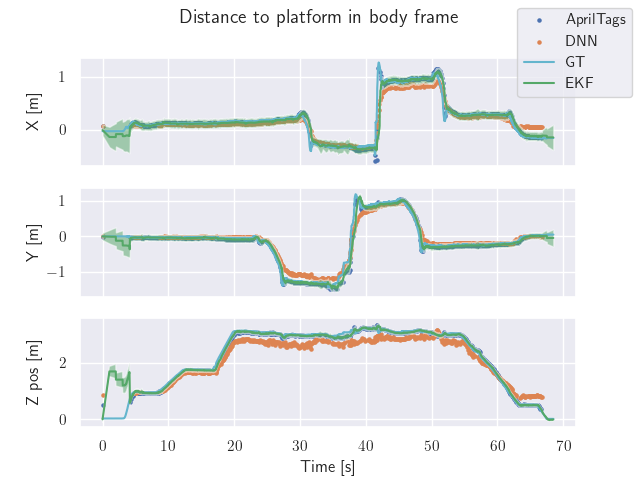

In [27]:
fig, axs = plt.subplots(3, 1)

axs[0].scatter(apriltag_data[:,0], apriltag_data[:,1], s=5)
axs[0].scatter(dnn_data[:,0], dnn_data[:,1], s=5)
axs[0].plot(GT_data[:,0], GT_data[:,1], c='c')
axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, 
                    label=r"$1\sigma$")
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].scatter(apriltag_data[:,0], apriltag_data[:,2], s=5)
axs[1].scatter(dnn_data[:,0], dnn_data[:,2], s=5)
axs[1].plot(GT_data[:,0], GT_data[:,2], c='c')
axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, 
                    label=r"$1\sigma$")
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])



axs[2].scatter(apriltag_data[:,0], apriltag_data[:,3], s=5)
axs[2].scatter(dnn_data[:,0], dnn_data[:,3], s=5)
axs[2].plot(GT_data[:,0], GT_data[:,3], c='c')
axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, 
                    label=r"$1\sigma$")
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z pos [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["AprilTags", "DNN", "GT", "EKF"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)
